# Generate Plots of Conversion Data

**Goal**: Visualize summary statistics of conversions.

In [1]:
import bd_mysql
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

sns.set;
%matplotlib inline

## Import and pre-process data

In [2]:
# Connect to database
config_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/cfg/mysql.cfg'
myDB = bd_mysql.connect_bd_mysql(config_path)

# Download data
df = bd_mysql.download_quote_data(myDB)

# Preprocess data
df = bd_mysql.pre_process_mysql(df)

## Plot quotes and conversion rates

In [3]:
# Convert year to int
df['year'] = df['year'].astype(int)

In [4]:
# group by year
gb_year = df.groupby('year')

In [40]:
# calculate yearly quotes
yearly_quotes = pd.DataFrame(df['year'].value_counts()).reset_index()
yearly_quotes.columns = ['year', 'quotes']

In [41]:
# calculate yearly conversion rate
yearly_conversion = pd.DataFrame(gb_year['converted'].agg(np.sum)).reset_index()
#yearly_conversion['converted'] = yearly_conversion['converted'] * 100
yearly_conversion.columns = ['year', 'converted']

In [43]:
yearly_conversion

,year,converted
0,2009,451
1,2010,474
2,2011,378
3,2012,356
4,2013,365
5,2014,368
6,2015,251
7,2016,43


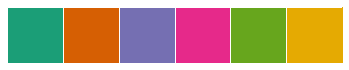

In [13]:
color_palette = sns.color_palette('Dark2')
sns.palplot(color_palette)

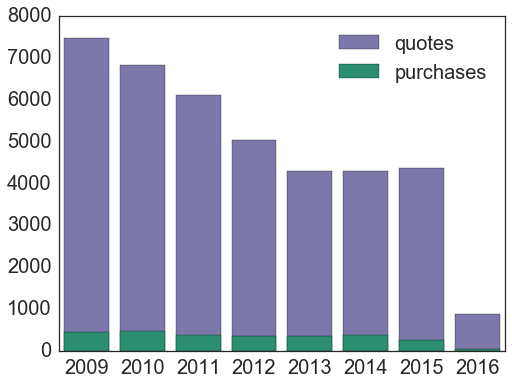

In [52]:
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
fig = plt.figure()
fig.set_size_inches(8, 6)

ax = fig.add_subplot(111)
sns.barplot(x = 'year', 
            y = 'quotes', 
            data = yearly_quotes, 
            color = color_palette[2], 
            label = 'quotes');
sns.barplot(x = 'year', 
            y = 'converted', 
            data = yearly_conversion, 
            color = color_palette[0],
            label = 'purchases');
plt.legend();
plt.xlabel('');
plt.ylabel('');

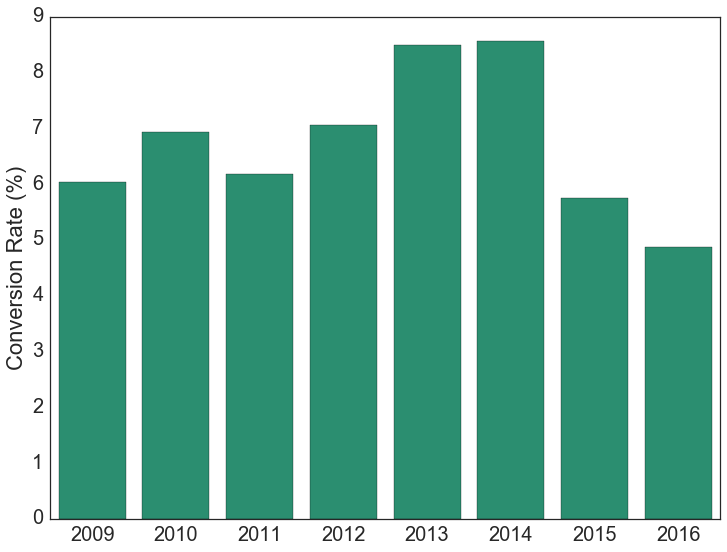

In [22]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.barplot(x = 'year', y = 'converted', data = yearly_conversion, color = color_palette[0]);
ax.set_xlabel('');
ax.set_ylabel('Conversion Rate (%)');
sns.set_context('notebook', font_scale=10)
fig.set_size_inches(12, 9)